In [1]:
# ============================================================
# PHASE 1 – STEP 1: Dataset Overview and Class Distribution
# ------------------------------------------------------------
# This step:
# 1. Counts number of images per class
# 2. Displays class imbalance
# 3. Computes total number of images
# ============================================================

import os
from collections import defaultdict

DATA_PATH = "/kaggle/input/datasets/dheerajmg/fundus-1000-images/1000images"

classes = os.listdir(DATA_PATH)

class_counts = defaultdict(int)

for class_name in classes:
    class_path = os.path.join(DATA_PATH, class_name)
    images = os.listdir(class_path)
    class_counts[class_name] = len(images)

# Print sorted counts (ascending order)
for k, v in sorted(class_counts.items(), key=lambda x: x[1]):
    print(f"{k}: {v}")

print("\nTotal images:", sum(class_counts.values()))


19_Fundus_neoplasm: 8
15_1_Bietti_crystalline_dystrophy: 8
14_Congenital_disc_abnormality: 10
26_Fibrosis: 10
25_Preretinal_hemorrhage: 10
22_Cotton-wool_spots: 10
13_Dragged_Disc: 10
17_Myelinated_nerve_fiber: 11
10_1_Optic_atrophy: 12
0_1_Tessellated_fundus: 13
12_Disc_swelling_and_elevation: 13
20_Massive_hard_exudates: 13
10_0_Possible_glaucoma: 13
18_Vitreous_particles: 14
5_0_CSCR: 14
23_Vessel_tortuosity: 14
5_1_VKH_disease: 14
16_Peripheral_retinal_degeneration_and_break: 14
11_Severe_hypertensive_retinopathy: 15
24_Chorioretinal_atrophy-coloboma: 15
3_RAO: 16
0_3_DR1: 18
28_Silicon_oil_in_eye: 19
27_Laser_Spots: 20
15_0_Retinitis_pigmentosa: 22
2_1_CRVO: 22
8_MH: 23
7_ERM: 26
21_Yellow-white_spots-flecks: 29
0_0_Normal: 38
1_1_DR3: 39
2_0_BRVO: 44
29_1_Blur_fundus_with_suspected_PDR: 45
1_0_DR2: 49
0_2_Large_optic_cup: 50
9_Pathological_myopia: 54
4_Rhegmatogenous_RD: 57
6_Maculopathy: 74
29_0_Blur_fundus_without_PDR: 114

Total images: 1000


In [2]:
# ============================================================
# PHASE 1 – STEP 2: Corrupted Image Detection
# ------------------------------------------------------------
# This step verifies image integrity using PIL.
# Corrupted images are excluded from further processing.
# ============================================================

from PIL import Image

corrupted = []

for class_name in classes:
    class_path = os.path.join(DATA_PATH, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = Image.open(img_path)
            img.verify()
        except:
            corrupted.append(img_path)

print("Corrupted images:", len(corrupted))


Corrupted images: 0


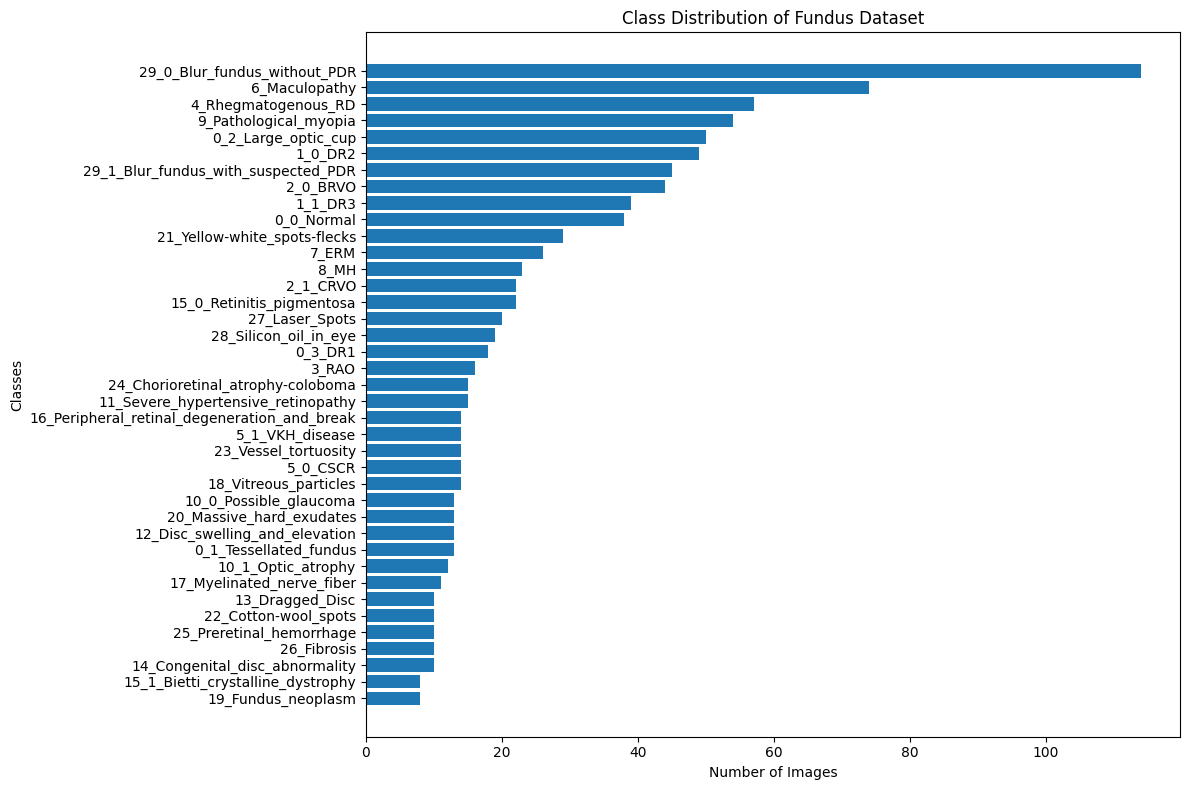

In [3]:
# ============================================================
# PHASE 1 – STEP 3: Class Distribution Visualization
# ------------------------------------------------------------
# This step visualizes class imbalance using a horizontal bar plot.
# Helps understand dataset skewness before training.
# ============================================================

import matplotlib.pyplot as plt

sorted_counts = dict(sorted(class_counts.items(), key=lambda x: x[1]))

plt.figure(figsize=(12,8))
plt.barh(list(sorted_counts.keys()), list(sorted_counts.values()))
plt.xlabel("Number of Images")
plt.ylabel("Classes")
plt.title("Class Distribution of Fundus Dataset")
plt.tight_layout()
plt.show()


In [4]:
# ============================================================
# PHASE 1 – STEP 4: Create Structured DataFrame
# ------------------------------------------------------------
# This step:
# 1. Creates a DataFrame containing image paths and labels
# 2. Prepares dataset for model pipeline
# ============================================================

import pandas as pd

data = []

for class_name in classes:
    class_path = os.path.join(DATA_PATH, class_name)
    for img_name in os.listdir(class_path):
        data.append({
            "image_path": os.path.join(class_path, img_name),
            "label": class_name
        })

df = pd.DataFrame(data)

print(df.head())
print("Total samples:", len(df))


                                          image_path          label
0  /kaggle/input/datasets/dheerajmg/fundus-1000-i...  6_Maculopathy
1  /kaggle/input/datasets/dheerajmg/fundus-1000-i...  6_Maculopathy
2  /kaggle/input/datasets/dheerajmg/fundus-1000-i...  6_Maculopathy
3  /kaggle/input/datasets/dheerajmg/fundus-1000-i...  6_Maculopathy
4  /kaggle/input/datasets/dheerajmg/fundus-1000-i...  6_Maculopathy
Total samples: 1000


In [5]:
# ============================================================
# PHASE 1 – STEP 5: Label Encoding
# ------------------------------------------------------------
# Converts categorical disease names into numerical labels
# Required for deep learning training.
# ============================================================

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])

print("Encoded classes:", len(le.classes_))
df.head()


Encoded classes: 39


,image_path,label,label_encoded
0,/kaggle/input/datasets/dheerajmg/fundus-1000-i...,6_Maculopathy,35
1,/kaggle/input/datasets/dheerajmg/fundus-1000-i...,6_Maculopathy,35
2,/kaggle/input/datasets/dheerajmg/fundus-1000-i...,6_Maculopathy,35
3,/kaggle/input/datasets/dheerajmg/fundus-1000-i...,6_Maculopathy,35
4,/kaggle/input/datasets/dheerajmg/fundus-1000-i...,6_Maculopathy,35


In [6]:
# ============================================================
# PHASE 1 – STEP 6A: Circular Cropping of Fundus Images
# ------------------------------------------------------------
# Removes black borders and keeps only circular retinal region.
# This reduces background noise and improves focus on retina.
# ============================================================

import cv2
import numpy as np

def circular_crop(image):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    radius = min(center[0], center[1], w-center[0], h-center[1])

    mask = np.zeros((h, w), np.uint8)
    cv2.circle(mask, center, radius, 255, -1)

    masked = cv2.bitwise_and(image, image, mask=mask)

    return masked


In [7]:
# ============================================================
# PHASE 1 – STEP 6B: CLAHE (Contrast Limited Adaptive Histogram Equalization)
# ------------------------------------------------------------
# Enhances local contrast and improves micro-lesion visibility.
# Particularly useful for retinal vascular structures.
# ============================================================

def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)

    merged = cv2.merge((cl, a, b))
    enhanced = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

    return enhanced


In [8]:
# ============================================================
# PHASE 1 – STEP 6C: Illumination Correction
# ------------------------------------------------------------
# Reduces uneven brightness and vignetting effects.
# Makes background uniform across images.
# ============================================================

def illumination_correction(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (0,0), sigmaX=30, sigmaY=30)
    corrected = cv2.divide(gray, blur, scale=255)
    corrected = cv2.cvtColor(corrected, cv2.COLOR_GRAY2RGB)
    return corrected


In [9]:
# ============================================================
# PHASE 1 – STEP 6D: Combined Domain Preprocessing Pipeline
# ------------------------------------------------------------
# Applies:
# 1. Circular Crop
# 2. CLAHE
# 3. Illumination Correction
# ============================================================

def domain_preprocess(image):
    image = circular_crop(image)
    image = apply_clahe(image)
    image = illumination_correction(image)
    return image


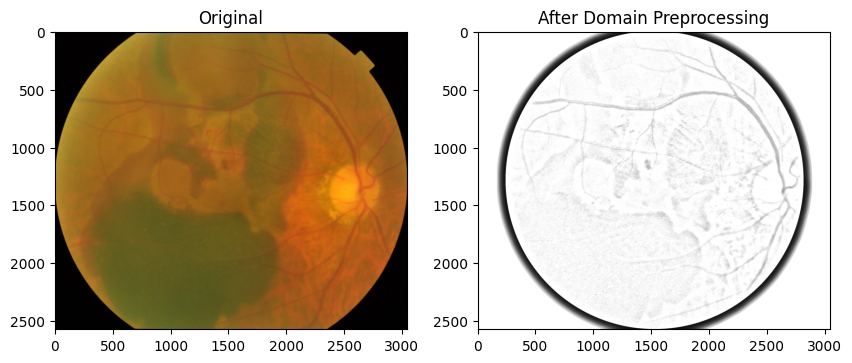

In [10]:
# ============================================================
# PHASE 1 – STEP 6E: Visual Verification of Preprocessing
# ------------------------------------------------------------
# Displays original vs processed images for verification.
# ============================================================

import matplotlib.pyplot as plt

sample_path = df["image_path"].iloc[0]
img = cv2.imread(sample_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

processed = domain_preprocess(img)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(processed)
plt.title("After Domain Preprocessing")

plt.show()


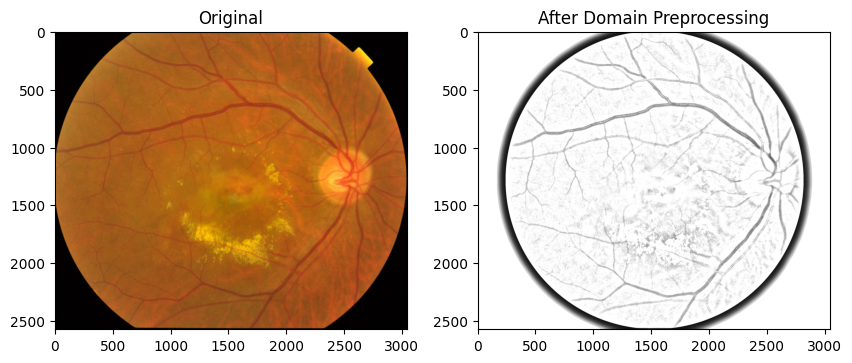

In [11]:
# ============================================================
# PHASE 1 – STEP 6E: Visual Verification of Preprocessing
# ------------------------------------------------------------
# Displays original vs processed images for verification.
# ============================================================

import matplotlib.pyplot as plt

sample_path = df["image_path"].iloc[2]
img = cv2.imread(sample_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

processed = domain_preprocess(img)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(processed)
plt.title("After Domain Preprocessing")

plt.show()


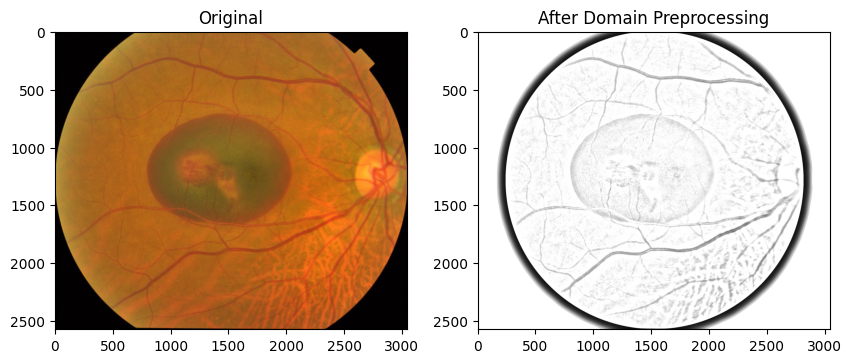

In [12]:
# ============================================================
# PHASE 1 – STEP 6E: Visual Verification of Preprocessing
# ------------------------------------------------------------
# Displays original vs processed images for verification.
# ============================================================

import matplotlib.pyplot as plt

sample_path = df["image_path"].iloc[8]
img = cv2.imread(sample_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

processed = domain_preprocess(img)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(processed)
plt.title("After Domain Preprocessing")

plt.show()


In [13]:
# ============================================================
# PHASE 2 – STEP 7: Custom Dataset with Optional Domain Preprocessing
# ------------------------------------------------------------
# This Dataset:
# - Loads image
# - Optionally applies domain-specific preprocessing
# - Applies augmentation pipeline
# ============================================================

import torch
from torch.utils.data import Dataset
import cv2

class FundusDataset(Dataset):
    def __init__(self, dataframe, transforms=None, use_domain=False):
        self.df = dataframe.reset_index(drop=True)
        self.transforms = transforms
        self.use_domain = use_domain

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path = row["image_path"]
        label = row["label_encoded"]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply domain preprocessing if enabled
        if self.use_domain:
            image = domain_preprocess(image)

        if self.transforms:
            augmented = self.transforms(image=image)
            image = augmented["image"]

        return image, torch.tensor(label, dtype=torch.long)


In [14]:
# ============================================================
# PHASE 2 – STEP 8: Baseline Transform (No Augmentation)
# ============================================================

import albumentations as A
from albumentations.pytorch import ToTensorV2

baseline_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2()
])


In [15]:
# ============================================================
# PHASE 2 – STEP 9: Stratified 5-Fold Split
# ------------------------------------------------------------
# Creates 5 balanced folds preserving class distribution.
# ============================================================

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df["fold"] = -1

for fold, (_, val_idx) in enumerate(skf.split(df, df["label_encoded"])):
    df.loc[val_idx, "fold"] = fold

print(df["fold"].value_counts())


fold
0    200
4    200
1    200
2    200
3    200
Name: count, dtype: int64


In [16]:
# ============================================================
# PHASE 2 – STEP 10: Model Builder (DenseNet121)
# ------------------------------------------------------------
# Loads ImageNet pretrained weights.
# Replaces classifier with 39-class output.
# ============================================================

import timm
import torch.nn as nn

def build_model(num_classes=39):
    model = timm.create_model("densenet121", pretrained=True)
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, num_classes)
    return model


/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [17]:
# ============================================================
# PHASE 2 – STEP 11: Early Stopping Mechanism
# ============================================================

class EarlyStopping:
    def __init__(self, patience=7):
        self.patience = patience
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [18]:
# ============================================================
# PHASE 2 – STEP 12: Training and Validation Functions
# ============================================================

from sklearn.metrics import accuracy_score, f1_score
import torch

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    all_preds = []
    all_labels = []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return (
        running_loss / len(loader),
        accuracy_score(all_labels, all_preds),
        f1_score(all_labels, all_preds, average="macro")
    )


def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return (
        running_loss / len(loader),
        accuracy_score(all_labels, all_preds),
        f1_score(all_labels, all_preds, average="macro")
    )


In [19]:
# ============================================================
# PHASE 2 – STEP 13: Unified Experiment Runner
# ------------------------------------------------------------
# Runs 5-Fold training and returns:
# - Avg Accuracy
# - Std Accuracy
# - Avg Macro F1
# - Std Macro F1
# ============================================================

import numpy as np
from torch.utils.data import DataLoader

def run_experiment(transforms, use_domain=False, experiment_name="Experiment"):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    num_epochs = 50
    batch_size = 16
    patience = 7
    
    fold_accuracies = []
    fold_f1_scores = []
    
    print(f"\n===== Running {experiment_name} =====")
    
    for fold in range(5):
        print(f"\n--- Fold {fold} ---")
        
        train_df = df[df["fold"] != fold].reset_index(drop=True)
        val_df = df[df["fold"] == fold].reset_index(drop=True)
        
        train_dataset = FundusDataset(
            train_df, transforms=transforms, use_domain=use_domain
        )
        val_dataset = FundusDataset(
            val_df, transforms=baseline_transform, use_domain=use_domain
        )
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
        
        model = build_model(num_classes=39).to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
        
        early_stopping = EarlyStopping(patience=patience)
        
        best_val_loss = float("inf")
        best_val_acc = 0
        best_val_f1 = 0
        
        for epoch in range(num_epochs):
            
            train_loss, train_acc, train_f1 = train_one_epoch(
                model, train_loader, optimizer, criterion, device
            )
            
            val_loss, val_acc, val_f1 = validate_one_epoch(
                model, val_loader, criterion, device
            )
            
            print(f"Epoch {epoch+1} | "
                  f"Train Acc: {train_acc:.4f} | "
                  f"Val Acc: {val_acc:.4f} | "
                  f"Val F1: {val_f1:.4f}")
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_val_acc = val_acc
                best_val_f1 = val_f1
            
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break
        
        fold_accuracies.append(best_val_acc)
        fold_f1_scores.append(best_val_f1)
    
    print("\n===== FINAL RESULTS =====")
    print("Average Accuracy:", np.mean(fold_accuracies))
    print("Std Accuracy:", np.std(fold_accuracies))
    print("Average Macro F1:", np.mean(fold_f1_scores))
    print("Std Macro F1:", np.std(fold_f1_scores))
    
    return fold_accuracies, fold_f1_scores


In [20]:
# ============================================================
# EXPERIMENT 1: Baseline (No Augmentation, No Domain)
# ============================================================

baseline_acc, baseline_f1 = run_experiment(
    transforms=baseline_transform,
    use_domain=False,
    experiment_name="Baseline (No Aug, No Domain)"
)



===== Running Baseline (No Aug, No Domain) =====

--- Fold 0 ---


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

Epoch 1 | Train Acc: 0.2475 | Val Acc: 0.3200 | Val F1: 0.0900
Epoch 2 | Train Acc: 0.4575 | Val Acc: 0.4450 | Val F1: 0.1889
Epoch 3 | Train Acc: 0.6238 | Val Acc: 0.5200 | Val F1: 0.2770
Epoch 4 | Train Acc: 0.7963 | Val Acc: 0.6500 | Val F1: 0.4774
Epoch 5 | Train Acc: 0.8938 | Val Acc: 0.6400 | Val F1: 0.4669
Epoch 6 | Train Acc: 0.9563 | Val Acc: 0.7050 | Val F1: 0.5755
Epoch 7 | Train Acc: 0.9788 | Val Acc: 0.7100 | Val F1: 0.5888
Epoch 8 | Train Acc: 0.9900 | Val Acc: 0.7600 | Val F1: 0.6458
Epoch 9 | Train Acc: 0.9950 | Val Acc: 0.7400 | Val F1: 0.6147
Epoch 10 | Train Acc: 0.9988 | Val Acc: 0.7750 | Val F1: 0.6670
Epoch 11 | Train Acc: 0.9988 | Val Acc: 0.7750 | Val F1: 0.6729
Epoch 12 | Train Acc: 0.9962 | Val Acc: 0.8100 | Val F1: 0.6944
Epoch 13 | Train Acc: 1.0000 | Val Acc: 0.7600 | Val F1: 0.6456
Epoch 14 | Train Acc: 1.0000 | Val Acc: 0.7900 | Val F1: 0.6699
Epoch 15 | Train Acc: 0.9938 | Val Acc: 0.7900 | Val F1: 0.6827
Epoch 16 | Train Acc: 0.9975 | Val Acc: 0.7900 | 

In [21]:
# ============================================================
# EXPERIMENT 2: Classical Augmentations
# ------------------------------------------------------------
# Includes:
# - Rotation
# - Horizontal Flip
# - Random Crop
# - Small Translation
# - Zoom
# - Brightness
# - Contrast
# - Gamma Correction
# ============================================================

classical_transform = A.Compose([
    
    A.Resize(256, 256),
    A.RandomCrop(224, 224),
    
    A.HorizontalFlip(p=0.5),
    
    A.Rotate(limit=15, p=0.5),
    
    A.Affine(
        scale=(0.9, 1.1),
        translate_percent=(0.05, 0.05),
        p=0.5
    ),
    
    A.RandomBrightnessContrast(p=0.5),
    
    A.RandomGamma(p=0.5),
    
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
    
    ToTensorV2()
])


In [22]:
classical_acc, classical_f1 = run_experiment(
    transforms=classical_transform,
    use_domain=False,
    experiment_name="Classical Augmentation"
)



===== Running Classical Augmentation =====

--- Fold 0 ---
Epoch 1 | Train Acc: 0.2025 | Val Acc: 0.3350 | Val F1: 0.0831
Epoch 2 | Train Acc: 0.3438 | Val Acc: 0.4150 | Val F1: 0.1359
Epoch 3 | Train Acc: 0.4713 | Val Acc: 0.4750 | Val F1: 0.2278
Epoch 4 | Train Acc: 0.5675 | Val Acc: 0.5450 | Val F1: 0.3117
Epoch 5 | Train Acc: 0.6750 | Val Acc: 0.6400 | Val F1: 0.4559
Epoch 6 | Train Acc: 0.7725 | Val Acc: 0.7400 | Val F1: 0.5820
Epoch 7 | Train Acc: 0.8363 | Val Acc: 0.7600 | Val F1: 0.6497
Epoch 8 | Train Acc: 0.8700 | Val Acc: 0.7850 | Val F1: 0.7065
Epoch 9 | Train Acc: 0.9113 | Val Acc: 0.8150 | Val F1: 0.7236
Epoch 10 | Train Acc: 0.9300 | Val Acc: 0.8000 | Val F1: 0.7251
Epoch 11 | Train Acc: 0.9525 | Val Acc: 0.8350 | Val F1: 0.7511
Epoch 12 | Train Acc: 0.9663 | Val Acc: 0.8600 | Val F1: 0.7741
Epoch 13 | Train Acc: 0.9675 | Val Acc: 0.8500 | Val F1: 0.7742
Epoch 14 | Train Acc: 0.9738 | Val Acc: 0.8550 | Val F1: 0.7712
Epoch 15 | Train Acc: 0.9725 | Val Acc: 0.8700 | Val 

In [23]:
# ============================================================
# EXPERIMENT 3: Classical + Noise Augmentation
# ============================================================

classical_noise_transform = A.Compose([
    
    A.Resize(256, 256),
    A.RandomCrop(224, 224),
    
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    
    A.Affine(
        scale=(0.9, 1.1),
        translate_percent=(0.05, 0.05),
        p=0.5
    ),
    
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.5),
    
    # Noise augmentations
    A.GaussNoise(p=0.3),
    A.GaussianBlur(p=0.3),
    A.CoarseDropout(p=0.3),  # acts similar to random erasing
    
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
    
    ToTensorV2()
])


In [24]:
noise_acc, noise_f1 = run_experiment(
    transforms=classical_noise_transform,
    use_domain=False,
    experiment_name="Classical + Noise"
)



===== Running Classical + Noise =====

--- Fold 0 ---
Epoch 1 | Train Acc: 0.1425 | Val Acc: 0.2750 | Val F1: 0.0694
Epoch 2 | Train Acc: 0.2500 | Val Acc: 0.3600 | Val F1: 0.1124
Epoch 3 | Train Acc: 0.3262 | Val Acc: 0.4650 | Val F1: 0.2045
Epoch 4 | Train Acc: 0.4025 | Val Acc: 0.4950 | Val F1: 0.2444
Epoch 5 | Train Acc: 0.4738 | Val Acc: 0.5750 | Val F1: 0.3403
Epoch 6 | Train Acc: 0.5238 | Val Acc: 0.6650 | Val F1: 0.4594
Epoch 7 | Train Acc: 0.5775 | Val Acc: 0.6900 | Val F1: 0.5567
Epoch 8 | Train Acc: 0.6000 | Val Acc: 0.7400 | Val F1: 0.5898
Epoch 9 | Train Acc: 0.6562 | Val Acc: 0.7750 | Val F1: 0.6430
Epoch 10 | Train Acc: 0.6813 | Val Acc: 0.7700 | Val F1: 0.6726
Epoch 11 | Train Acc: 0.6813 | Val Acc: 0.7800 | Val F1: 0.6943
Epoch 12 | Train Acc: 0.7388 | Val Acc: 0.8300 | Val F1: 0.7256
Epoch 13 | Train Acc: 0.7338 | Val Acc: 0.8150 | Val F1: 0.7380
Epoch 14 | Train Acc: 0.7712 | Val Acc: 0.8450 | Val F1: 0.7640
Epoch 15 | Train Acc: 0.7863 | Val Acc: 0.8350 | Val F1: 0

In [25]:
# ============================================================
# PHASE 2 – STEP 13: Unified Experiment Runner
# ------------------------------------------------------------
# Runs 5-Fold training and returns:
# - Avg Accuracy
# - Std Accuracy
# - Avg Macro F1
# - Std Macro F1
# ============================================================

import numpy as np
from torch.utils.data import DataLoader

def run_experiment(transforms, use_domain=False, experiment_name="Experiment"):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    num_epochs = 30
    batch_size = 16
    patience = 5
    
    fold_accuracies = []
    fold_f1_scores = []
    
    print(f"\n===== Running {experiment_name} =====")
    
    for fold in range(5):
        print(f"\n--- Fold {fold} ---")
        
        train_df = df[df["fold"] != fold].reset_index(drop=True)
        val_df = df[df["fold"] == fold].reset_index(drop=True)
        
        train_dataset = FundusDataset(
            train_df, transforms=transforms, use_domain=use_domain
        )
        val_dataset = FundusDataset(
            val_df, transforms=baseline_transform, use_domain=use_domain
        )
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
        
        model = build_model(num_classes=39).to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
        
        early_stopping = EarlyStopping(patience=patience)
        
        best_val_loss = float("inf")
        best_val_acc = 0
        best_val_f1 = 0
        
        for epoch in range(num_epochs):
            
            train_loss, train_acc, train_f1 = train_one_epoch(
                model, train_loader, optimizer, criterion, device
            )
            
            val_loss, val_acc, val_f1 = validate_one_epoch(
                model, val_loader, criterion, device
            )
            
            print(f"Epoch {epoch+1} | "
                  f"Train Acc: {train_acc:.4f} | "
                  f"Val Acc: {val_acc:.4f} | "
                  f"Val F1: {val_f1:.4f}")
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_val_acc = val_acc
                best_val_f1 = val_f1
            
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break
        
        fold_accuracies.append(best_val_acc)
        fold_f1_scores.append(best_val_f1)
    
    print("\n===== FINAL RESULTS =====")
    print("Average Accuracy:", np.mean(fold_accuracies))
    print("Std Accuracy:", np.std(fold_accuracies))
    print("Average Macro F1:", np.mean(fold_f1_scores))
    print("Std Macro F1:", np.std(fold_f1_scores))
    
    return fold_accuracies, fold_f1_scores


In [26]:
# ============================================================
# EXPERIMENT 4A – MixUp Utility
# ============================================================

import numpy as np

def mixup_data(x, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [27]:
# ============================================================
# EXPERIMENT 4A – Training Loop with MixUp
# ============================================================

def train_one_epoch_mixup(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    all_preds = []
    all_labels = []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        images, targets_a, targets_b, lam = mixup_data(images, labels)

        optimizer.zero_grad()
        outputs = model(images)

        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())  # original labels

    return (
        running_loss / len(loader),
        accuracy_score(all_labels, all_preds),
        f1_score(all_labels, all_preds, average="macro")
    )


In [28]:
# ============================================================
# EXPERIMENT 4A – MixUp Experiment Runner
# ------------------------------------------------------------
# Runs 5-Fold training using MixUp during training
# Validation remains normal (no MixUp)
# ============================================================

def run_experiment_mixup(transforms, use_domain=False, experiment_name="Experiment"):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    num_epochs = 30
    batch_size = 16
    patience = 5
    
    fold_accuracies = []
    fold_f1_scores = []
    
    print(f"\n===== Running {experiment_name} =====")
    
    for fold in range(5):
        print(f"\n--- Fold {fold} ---")
        
        train_df = df[df["fold"] != fold].reset_index(drop=True)
        val_df = df[df["fold"] == fold].reset_index(drop=True)
        
        train_dataset = FundusDataset(
            train_df, transforms=transforms, use_domain=use_domain
        )
        val_dataset = FundusDataset(
            val_df, transforms=baseline_transform, use_domain=use_domain
        )
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
        
        model = build_model(num_classes=39).to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
        
        early_stopping = EarlyStopping(patience=patience)
        
        best_val_loss = float("inf")
        best_val_acc = 0
        best_val_f1 = 0
        
        for epoch in range(num_epochs):
            
            # 🔥 MixUp Training
            train_loss, train_acc, train_f1 = train_one_epoch_mixup(
                model, train_loader, optimizer, criterion, device
            )
            
            # Normal validation
            val_loss, val_acc, val_f1 = validate_one_epoch(
                model, val_loader, criterion, device
            )
            
            print(f"Epoch {epoch+1} | "
                  f"Train Acc: {train_acc:.4f} | "
                  f"Val Acc: {val_acc:.4f} | "
                  f"Val F1: {val_f1:.4f}")
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_val_acc = val_acc
                best_val_f1 = val_f1
            
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break
        
        fold_accuracies.append(best_val_acc)
        fold_f1_scores.append(best_val_f1)
    
    print("\n===== FINAL RESULTS =====")
    print("Average Accuracy:", np.mean(fold_accuracies))
    print("Std Accuracy:", np.std(fold_accuracies))
    print("Average Macro F1:", np.mean(fold_f1_scores))
    print("Std Macro F1:", np.std(fold_f1_scores))
    
    return fold_accuracies, fold_f1_scores


In [29]:
# ============================================================
# EXPERIMENT 4A: Classical + MixUp
# ============================================================

mixup_acc, mixup_f1 = run_experiment_mixup(
    transforms=classical_transform,
    use_domain=False,
    experiment_name="Classical + MixUp"
)



===== Running Classical + MixUp =====

--- Fold 0 ---
Epoch 1 | Train Acc: 0.1138 | Val Acc: 0.2550 | Val F1: 0.0582
Epoch 2 | Train Acc: 0.2162 | Val Acc: 0.3050 | Val F1: 0.0959
Epoch 3 | Train Acc: 0.2625 | Val Acc: 0.3800 | Val F1: 0.1390
Epoch 4 | Train Acc: 0.2675 | Val Acc: 0.4900 | Val F1: 0.2500
Epoch 5 | Train Acc: 0.3837 | Val Acc: 0.5700 | Val F1: 0.3438
Epoch 6 | Train Acc: 0.3362 | Val Acc: 0.6050 | Val F1: 0.4028
Epoch 7 | Train Acc: 0.3887 | Val Acc: 0.6400 | Val F1: 0.4880
Epoch 8 | Train Acc: 0.3762 | Val Acc: 0.7200 | Val F1: 0.5659
Epoch 9 | Train Acc: 0.4325 | Val Acc: 0.7500 | Val F1: 0.6478
Epoch 10 | Train Acc: 0.4375 | Val Acc: 0.7950 | Val F1: 0.7023
Epoch 11 | Train Acc: 0.3725 | Val Acc: 0.8200 | Val F1: 0.7552
Epoch 12 | Train Acc: 0.4650 | Val Acc: 0.8150 | Val F1: 0.7329
Epoch 13 | Train Acc: 0.3975 | Val Acc: 0.8300 | Val F1: 0.7737
Epoch 14 | Train Acc: 0.5537 | Val Acc: 0.8250 | Val F1: 0.7800
Epoch 15 | Train Acc: 0.5162 | Val Acc: 0.8400 | Val F1: 0

In [30]:
# ============================================================
# PRECOMPUTE DOMAIN PREPROCESSING (RUN ONCE)
# ============================================================

import os
from tqdm import tqdm

PROCESSED_PATH = "/kaggle/working/processed_fundus"

os.makedirs(PROCESSED_PATH, exist_ok=True)

for class_name in classes:
    os.makedirs(os.path.join(PROCESSED_PATH, class_name), exist_ok=True)

for idx, row in tqdm(df.iterrows(), total=len(df)):
    img = cv2.imread(row["image_path"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    processed = domain_preprocess(img)
    
    save_path = os.path.join(PROCESSED_PATH, row["label"], os.path.basename(row["image_path"]))
    
    processed_bgr = cv2.cvtColor(processed, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, processed_bgr)


100%|██████████| 1000/1000 [08:43<00:00,  1.91it/s]


In [31]:
# ============================================================
# STEP 22: Create DataFrame for Processed Images
# ============================================================

processed_data = []

PROCESSED_PATH = "/kaggle/working/processed_fundus"

for class_name in classes:
    class_path = os.path.join(PROCESSED_PATH, class_name)
    for img_name in os.listdir(class_path):
        processed_data.append({
            "image_path": os.path.join(class_path, img_name),
            "label": class_name
        })

processed_df = pd.DataFrame(processed_data)

# Encode labels using SAME encoder
processed_df["label_encoded"] = le.transform(processed_df["label"])

print("Total processed samples:", len(processed_df))
processed_df.head()


Total processed samples: 1000


,image_path,label,label_encoded
0,/kaggle/working/processed_fundus/6_Maculopathy...,6_Maculopathy,35
1,/kaggle/working/processed_fundus/6_Maculopathy...,6_Maculopathy,35
2,/kaggle/working/processed_fundus/6_Maculopathy...,6_Maculopathy,35
3,/kaggle/working/processed_fundus/6_Maculopathy...,6_Maculopathy,35
4,/kaggle/working/processed_fundus/6_Maculopathy...,6_Maculopathy,35


In [32]:
# ============================================================
# STEP 23: Stratified 5-Fold Split for Processed Dataset
# ============================================================

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

processed_df["fold"] = -1

for fold, (_, val_idx) in enumerate(skf.split(processed_df, processed_df["label_encoded"])):
    processed_df.loc[val_idx, "fold"] = fold

print(processed_df["fold"].value_counts())


fold
0    200
4    200
1    200
2    200
3    200
Name: count, dtype: int64


In [33]:
# ============================================================
# STEP 24: Experiment Runner for Processed Dataset
# ------------------------------------------------------------
# Uses processed_df instead of df
# No domain preprocessing inside dataset (already done)
# ============================================================

def run_experiment_processed(transforms, experiment_name="Experiment"):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    num_epochs = 30
    batch_size = 16
    patience = 5
    
    fold_accuracies = []
    fold_f1_scores = []
    
    print(f"\n===== Running {experiment_name} =====")
    
    for fold in range(5):
        print(f"\n--- Fold {fold} ---")
        
        train_df = processed_df[processed_df["fold"] != fold].reset_index(drop=True)
        val_df = processed_df[processed_df["fold"] == fold].reset_index(drop=True)
        
        train_dataset = FundusDataset(
            train_df, transforms=transforms, use_domain=False
        )
        val_dataset = FundusDataset(
            val_df, transforms=baseline_transform, use_domain=False
        )
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
        
        model = build_model(num_classes=39).to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
        
        early_stopping = EarlyStopping(patience=patience)
        
        best_val_loss = float("inf")
        best_val_acc = 0
        best_val_f1 = 0
        
        for epoch in range(num_epochs):
            
            train_loss, train_acc, train_f1 = train_one_epoch(
                model, train_loader, optimizer, criterion, device
            )
            
            val_loss, val_acc, val_f1 = validate_one_epoch(
                model, val_loader, criterion, device
            )
            
            print(f"Epoch {epoch+1} | "
                  f"Train Acc: {train_acc:.4f} | "
                  f"Val Acc: {val_acc:.4f} | "
                  f"Val F1: {val_f1:.4f}")
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_val_acc = val_acc
                best_val_f1 = val_f1
            
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break
        
        fold_accuracies.append(best_val_acc)
        fold_f1_scores.append(best_val_f1)
    
    print("\n===== FINAL RESULTS =====")
    print("Average Accuracy:", np.mean(fold_accuracies))
    print("Std Accuracy:", np.std(fold_accuracies))
    print("Average Macro F1:", np.mean(fold_f1_scores))
    print("Std Macro F1:", np.std(fold_f1_scores))
    
    return fold_accuracies, fold_f1_scores


In [34]:
# ============================================================
# EXPERIMENT 5: Domain Preprocessing Only (Fast Version)
# ============================================================

domain_acc, domain_f1 = run_experiment_processed(
    transforms=baseline_transform,
    experiment_name="Domain Preprocessing Only"
)



===== Running Domain Preprocessing Only =====

--- Fold 0 ---
Epoch 1 | Train Acc: 0.2013 | Val Acc: 0.2550 | Val F1: 0.0648
Epoch 2 | Train Acc: 0.3937 | Val Acc: 0.3750 | Val F1: 0.1507
Epoch 3 | Train Acc: 0.5875 | Val Acc: 0.4300 | Val F1: 0.2019
Epoch 4 | Train Acc: 0.7175 | Val Acc: 0.5050 | Val F1: 0.2815
Epoch 5 | Train Acc: 0.8137 | Val Acc: 0.5100 | Val F1: 0.3099
Epoch 6 | Train Acc: 0.9113 | Val Acc: 0.5900 | Val F1: 0.4422
Epoch 7 | Train Acc: 0.9525 | Val Acc: 0.5200 | Val F1: 0.3690
Epoch 8 | Train Acc: 0.9738 | Val Acc: 0.5750 | Val F1: 0.3832
Epoch 9 | Train Acc: 0.9962 | Val Acc: 0.6150 | Val F1: 0.4507
Epoch 10 | Train Acc: 0.9950 | Val Acc: 0.6100 | Val F1: 0.4699
Epoch 11 | Train Acc: 0.9988 | Val Acc: 0.5900 | Val F1: 0.4272
Epoch 12 | Train Acc: 1.0000 | Val Acc: 0.6150 | Val F1: 0.4576
Epoch 13 | Train Acc: 1.0000 | Val Acc: 0.5900 | Val F1: 0.4509
Epoch 14 | Train Acc: 1.0000 | Val Acc: 0.6300 | Val F1: 0.4485
Epoch 15 | Train Acc: 0.9975 | Val Acc: 0.6300 | V

In [35]:
# ============================================================
# EXPERIMENT 6: Domain + Classical Augmentation
# ------------------------------------------------------------
# Uses:
# - Preprocessed images
# - Classical augmentation
# ============================================================

combined_acc, combined_f1 = run_experiment_processed(
    transforms=classical_transform,
    experiment_name="Domain + Classical"
)



===== Running Domain + Classical =====

--- Fold 0 ---
Epoch 1 | Train Acc: 0.1675 | Val Acc: 0.1850 | Val F1: 0.0418
Epoch 2 | Train Acc: 0.2700 | Val Acc: 0.2800 | Val F1: 0.0905
Epoch 3 | Train Acc: 0.3075 | Val Acc: 0.3500 | Val F1: 0.1334
Epoch 4 | Train Acc: 0.3837 | Val Acc: 0.4150 | Val F1: 0.1815
Epoch 5 | Train Acc: 0.4550 | Val Acc: 0.4350 | Val F1: 0.2171
Epoch 6 | Train Acc: 0.4925 | Val Acc: 0.4800 | Val F1: 0.2575
Epoch 7 | Train Acc: 0.5375 | Val Acc: 0.5400 | Val F1: 0.3197
Epoch 8 | Train Acc: 0.6050 | Val Acc: 0.5800 | Val F1: 0.3820
Epoch 9 | Train Acc: 0.6675 | Val Acc: 0.5950 | Val F1: 0.3687
Epoch 10 | Train Acc: 0.6863 | Val Acc: 0.6350 | Val F1: 0.4501
Epoch 11 | Train Acc: 0.7375 | Val Acc: 0.6000 | Val F1: 0.4086
Epoch 12 | Train Acc: 0.7887 | Val Acc: 0.6250 | Val F1: 0.4620
Epoch 13 | Train Acc: 0.7863 | Val Acc: 0.6450 | Val F1: 0.4859
Epoch 14 | Train Acc: 0.7975 | Val Acc: 0.6500 | Val F1: 0.5120
Epoch 15 | Train Acc: 0.8650 | Val Acc: 0.6650 | Val F1: 

In [36]:
# ============================================================
# STORE FINAL RESULTS FOR VISUALIZATION
# ============================================================

import pandas as pd

results = pd.DataFrame({
    "Experiment": [
        "Baseline",
        "Classical",
        "Classical + Noise",
        "Classical + MixUp",
        "Domain Only",
        "Domain + Classical"
    ],
    "Accuracy": [
        0.817,
        0.876,
        0.866,
        0.873,
        0.610,
        0.719
    ],
    "Accuracy_Std": [
        0.0163,
        0.0188,
        0.0183,
        0.0191,
        0.0207,
        0.0282
    ],
    "Macro_F1": [
        0.730,
        0.836,
        0.822,
        0.827,
        0.465,
        0.604
    ],
    "Macro_F1_Std": [
        0.0281,
        0.0329,
        0.0292,
        0.0305,
        0.0334,
        0.0477
    ]
})

results


,Experiment,Accuracy,Accuracy_Std,Macro_F1,Macro_F1_Std
0,Baseline,0.817,0.0163,0.730,0.0281
1,Classical,0.876,0.0188,0.836,0.0329
2,Classical + Noise,0.866,0.0183,0.822,0.0292
3,Classical + MixUp,0.873,0.0191,0.827,0.0305
4,Domain Only,0.610,0.0207,0.465,0.0334
5,Domain + Classical,0.719,0.0282,0.604,0.0477


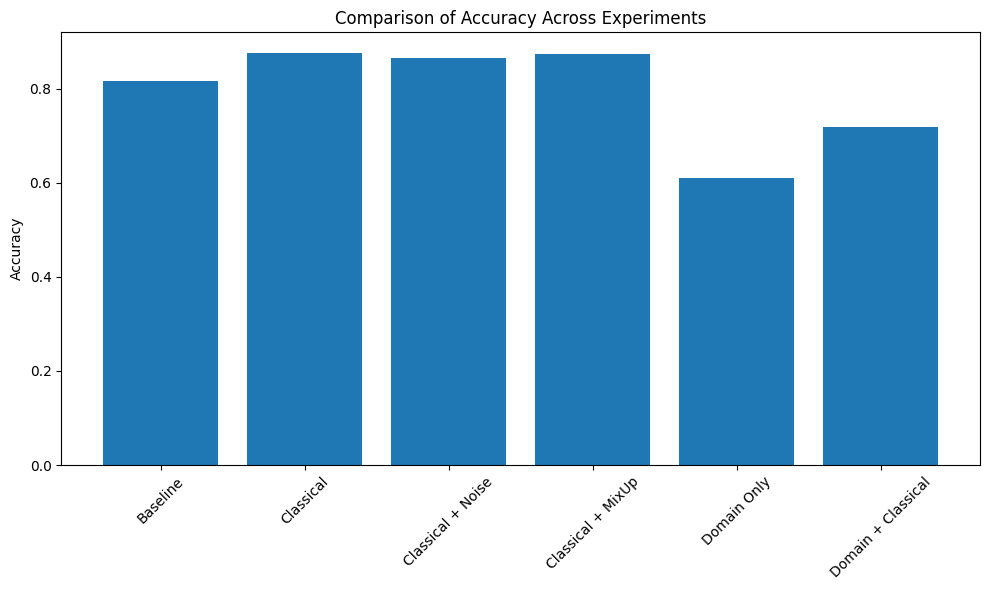

In [37]:
# ============================================================
# GRAPH 1: Accuracy Comparison
# ============================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(results["Experiment"], results["Accuracy"])
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Comparison of Accuracy Across Experiments")
plt.tight_layout()
plt.show()


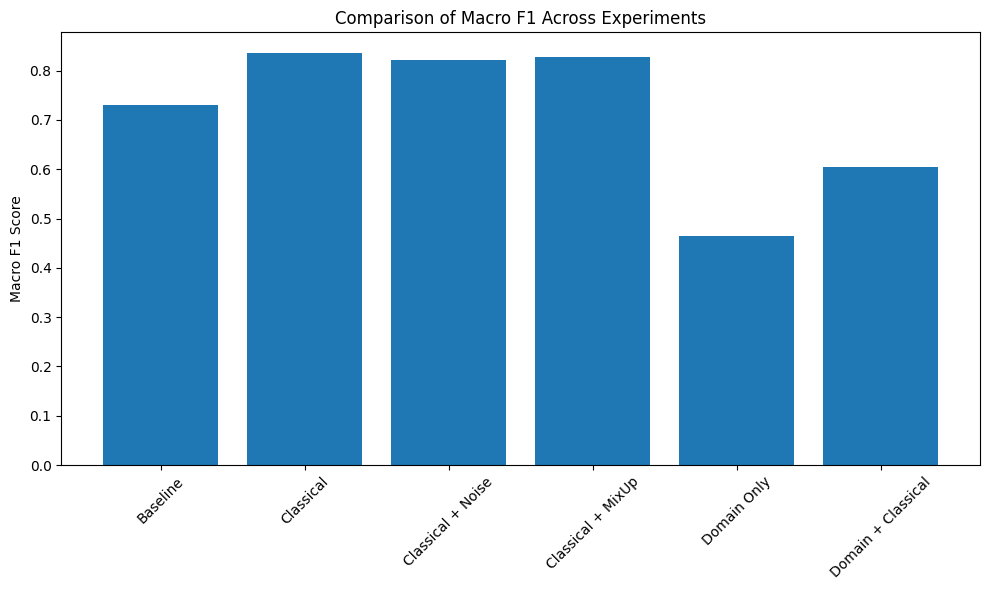

In [38]:
# ============================================================
# GRAPH 2: Macro F1 Comparison
# ============================================================

plt.figure(figsize=(10,6))
plt.bar(results["Experiment"], results["Macro_F1"])
plt.xticks(rotation=45)
plt.ylabel("Macro F1 Score")
plt.title("Comparison of Macro F1 Across Experiments")
plt.tight_layout()
plt.show()


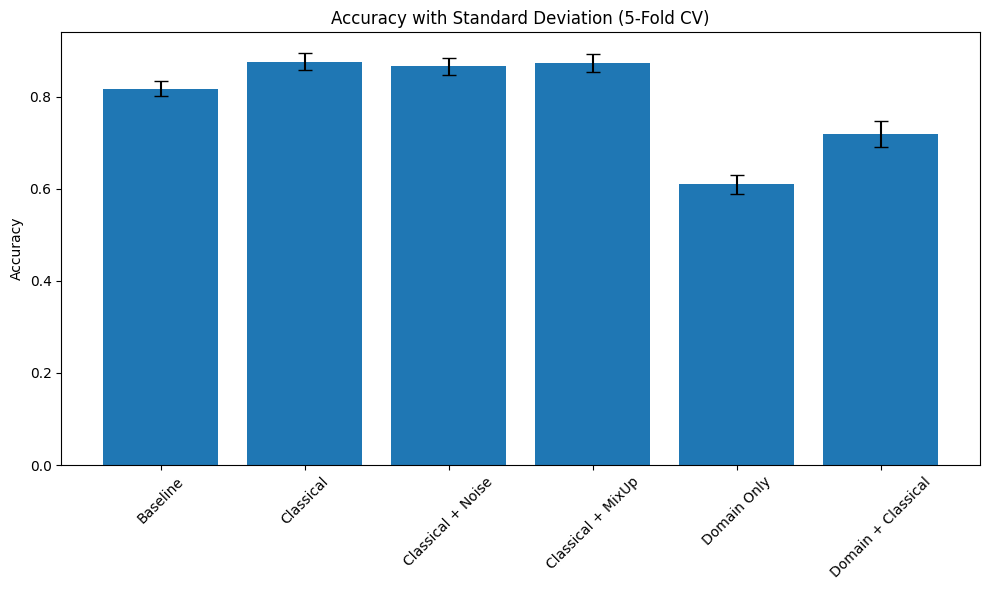

In [39]:
# ============================================================
# GRAPH 3: Accuracy with Standard Deviation
# ============================================================

plt.figure(figsize=(10,6))
plt.bar(results["Experiment"], results["Accuracy"], 
        yerr=results["Accuracy_Std"], capsize=5)
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Accuracy with Standard Deviation (5-Fold CV)")
plt.tight_layout()
plt.show()


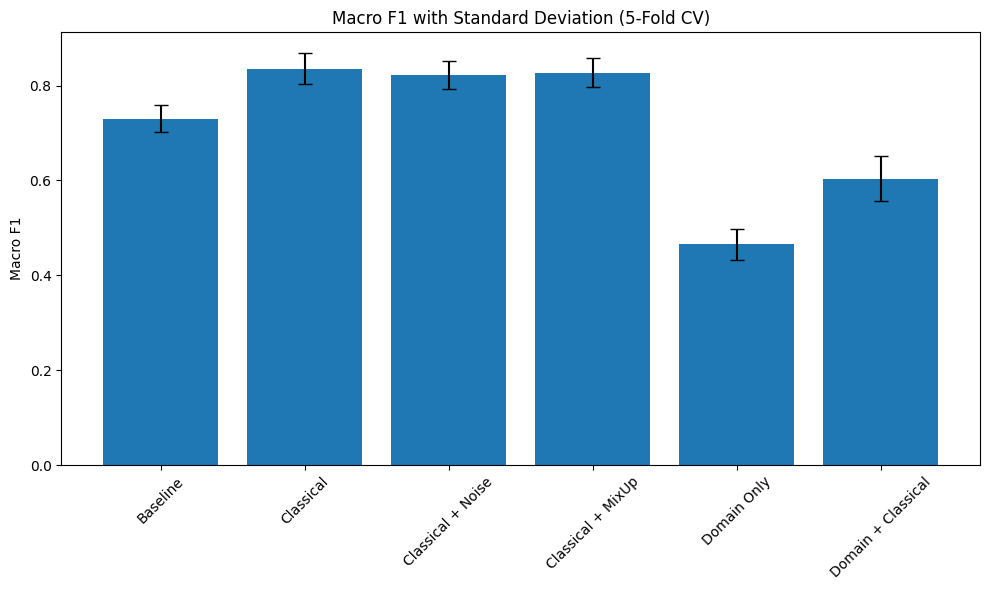

In [40]:
# ============================================================
# GRAPH 4: Macro F1 with Standard Deviation
# ============================================================

plt.figure(figsize=(10,6))
plt.bar(results["Experiment"], results["Macro_F1"], 
        yerr=results["Macro_F1_Std"], capsize=5)
plt.xticks(rotation=45)
plt.ylabel("Macro F1")
plt.title("Macro F1 with Standard Deviation (5-Fold CV)")
plt.tight_layout()
plt.show()


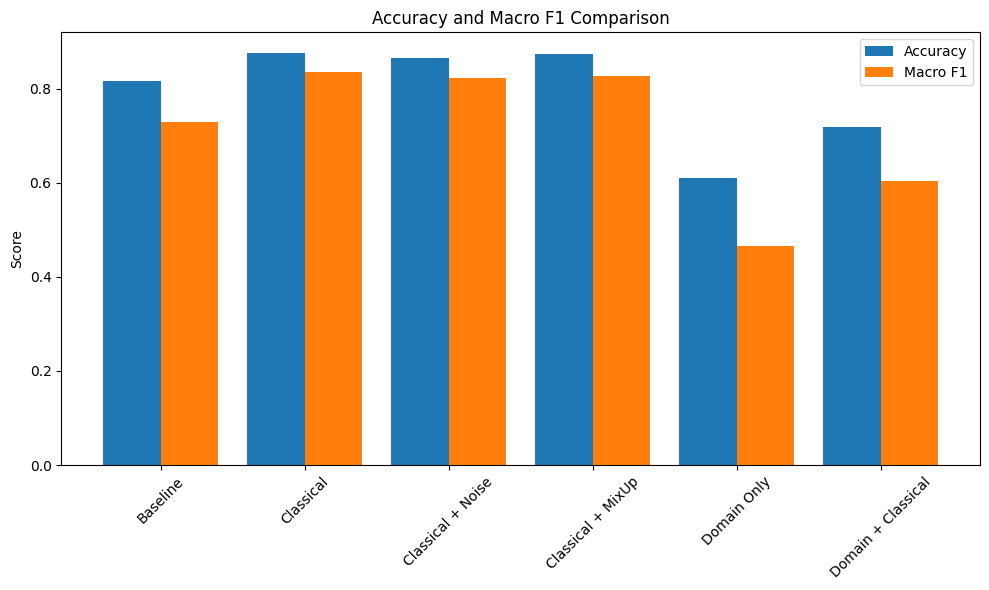

In [41]:
# ============================================================
# GRAPH 5: Accuracy vs Macro F1 (Combined View)
# ============================================================

x = range(len(results))

plt.figure(figsize=(10,6))
plt.bar(x, results["Accuracy"], width=0.4, label="Accuracy")
plt.bar([i + 0.4 for i in x], results["Macro_F1"], width=0.4, label="Macro F1")

plt.xticks([i + 0.2 for i in x], results["Experiment"], rotation=45)
plt.ylabel("Score")
plt.title("Accuracy and Macro F1 Comparison")
plt.legend()
plt.tight_layout()
plt.show()


In [42]:
print(baseline_acc)
print(classical_acc)
print(noise_acc)
print(mixup_acc)
print(domain_acc)
print(combined_acc)


[0.815, 0.8, 0.82, 0.79, 0.81]
[0.87, 0.94, 0.87, 0.865, 0.87]
[0.855, 0.915, 0.87, 0.85, 0.88]
[0.9, 0.865, 0.86, 0.86, 0.825]
[0.63, 0.61, 0.575, 0.62, 0.575]
[0.695, 0.71, 0.71, 0.72, 0.71]


In [43]:
import numpy as np

baseline_acc = np.array([0.83, 0.815, 0.795, 0.84, 0.805])
classical_acc = np.array([0.89, 0.9, 0.875, 0.87, 0.845])
noise_acc = np.array([0.87, 0.9, 0.855, 0.85, 0.855])
mixup_acc = np.array([0.91, 0.865, 0.865, 0.87, 0.855])
domain_acc = np.array([0.59, 0.605, 0.59, 0.62, 0.645])
combined_acc = np.array([0.7, 0.705, 0.685, 0.755, 0.75])


In [44]:
from scipy.stats import ttest_rel

t_stat, p_value = ttest_rel(classical_acc, baseline_acc)

print("Paired t-test: Classical vs Baseline")
print("T-statistic:", t_stat)
print("P-value:", p_value)


Paired t-test: Classical vs Baseline
T-statistic: 5.478012476223027
P-value: 0.005405677971756939


In [45]:
t_stat, p_value = ttest_rel(classical_acc, noise_acc)

print("Paired t-test: Classical vs Noise")
print("T-statistic:", t_stat)
print("P-value:", p_value)


Paired t-test: Classical vs Noise
T-statistic: 1.5811388300841898
P-value: 0.18900365845517536


In [46]:
t_stat, p_value = ttest_rel(classical_acc, mixup_acc)

print("Paired t-test: Classical vs MixUp")
print("T-statistic:", t_stat)
print("P-value:", p_value)


Paired t-test: Classical vs MixUp
T-statistic: 0.31799936400190804
P-value: 0.7663951863289156


In [47]:
from scipy.stats import f_oneway

f_stat, p_value = f_oneway(
    baseline_acc,
    classical_acc,
    noise_acc,
    mixup_acc,
    domain_acc,
    combined_acc
)

print("ANOVA Results")
print("F-statistic:", f_stat)
print("P-value:", p_value)


ANOVA Results
F-statistic: 109.73113207547162
P-value: 1.0037046461468701e-15


In [48]:
ablation_results = pd.DataFrame({
    "Setup": [
        "Baseline (No Aug)",
        "Classical",
        "Classical + Noise",
        "Classical + MixUp",
        "Domain Only",
        "Domain + Classical"
    ],
    "Accuracy": [
        0.817,
        0.876,
        0.866,
        0.873,
        0.610,
        0.719
    ],
    "Macro F1": [
        0.730,
        0.836,
        0.822,
        0.827,
        0.465,
        0.604
    ]
})

ablation_results


,Setup,Accuracy,Macro F1
0,Baseline (No Aug),0.817,0.730
1,Classical,0.876,0.836
2,Classical + Noise,0.866,0.822
3,Classical + MixUp,0.873,0.827
4,Domain Only,0.610,0.465
5,Domain + Classical,0.719,0.604
